In [46]:
import lenskit.datasets as ds
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

In [47]:
#creating data frames for csv

mov_df = pd.read_csv('data/movies.csv')
rat_df = pd.read_csv('data/ratings.csv')
tag_df = pd.read_csv('data/tags.csv')
lin_df = pd.read_csv('data/links.csv')

In [48]:
#peek at the data
mov_df.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [49]:
rat_df.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [50]:
tag_df

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


#### Joining data files
Since the dataset we are using have already been preprocessed by filling the missing data (such as reviews) with 0, all we need now is to join the data files so that informations from ratings and movies match.

In [51]:
joined_data = rat_df.join(mov_df.set_index('movieId')['genres'], on='movieId')
joined_data = joined_data.join(mov_df.set_index('movieId')['title'], on='movieId')

joined_data.head()

,userId,movieId,rating,timestamp,genres,title
0,1,1,4.0,964982703,Adventure|Animation|Children|Comedy|Fantasy,Toy Story (1995)
1,1,3,4.0,964981247,Comedy|Romance,Grumpier Old Men (1995)
2,1,6,4.0,964982224,Action|Crime|Thriller,Heat (1995)
3,1,47,5.0,964983815,Mystery|Thriller,Seven (a.k.a. Se7en) (1995)
4,1,50,5.0,964982931,Crime|Mystery|Thriller,"Usual Suspects, The (1995)"


### Recommended movies sets
First we will create a generic movie recommendation set will be created by filtering the data set by the amount of users who rated it.

In [52]:
user_filter = 100 #how many users rated movie

rat_amount = rat_df.groupby(['movieId']).count()
rat_mean = rat_df.groupby(['movieId']).mean()
rat_avg = rat_mean.loc[rat_amount['rating'] > user_filter]

sorted_rat_avg = rat_avg.sort_values(by="rating", inplace=False, ascending=False)

joined_data = sorted_rat_avg.join(mov_df.set_index('movieId')['genres'], on='movieId')
joined_data = joined_data.join(mov_df.set_index('movieId')['title'], on='movieId')
joined_data = joined_data[joined_data.columns[3:]]

print("recommended movies by highest rated:")
joined_data.head(10)

recommended movies by highest rated:


,genres,title
movieId,,
318,Crime|Drama,"Shawshank Redemption, The (1994)"
858,Crime|Drama,"Godfather, The (1972)"
2959,Action|Crime|Drama|Thriller,Fight Club (1999)
1221,Crime|Drama,"Godfather: Part II, The (1974)"
48516,Crime|Drama|Thriller,"Departed, The (2006)"
1213,Crime|Drama,Goodfellas (1990)
58559,Action|Crime|Drama|IMAX,"Dark Knight, The (2008)"
50,Crime|Mystery|Thriller,"Usual Suspects, The (1995)"
1197,Action|Adventure|Comedy|Fantasy|Romance,"Princess Bride, The (1987)"


#### Analysis of users and movies
Before creating personalized recommendations we can take a look at the movie genres and the userbase

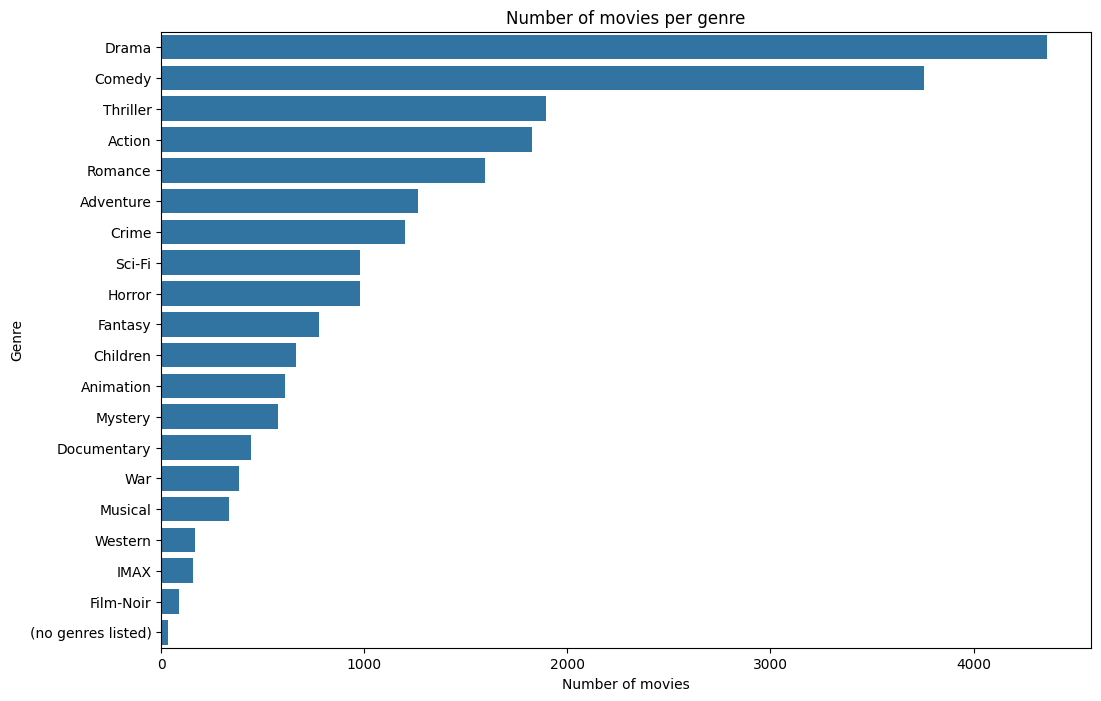

In [53]:
genre_counts = mov_df['genres'].str.split('|', expand=True).stack().value_counts()

plt.title('Number of movies per genre')
plt.xlabel('Number of movies')
plt.ylabel('Genre')
sns.barplot(x = genre_counts.values, y = genre_counts.index)
plt.show()

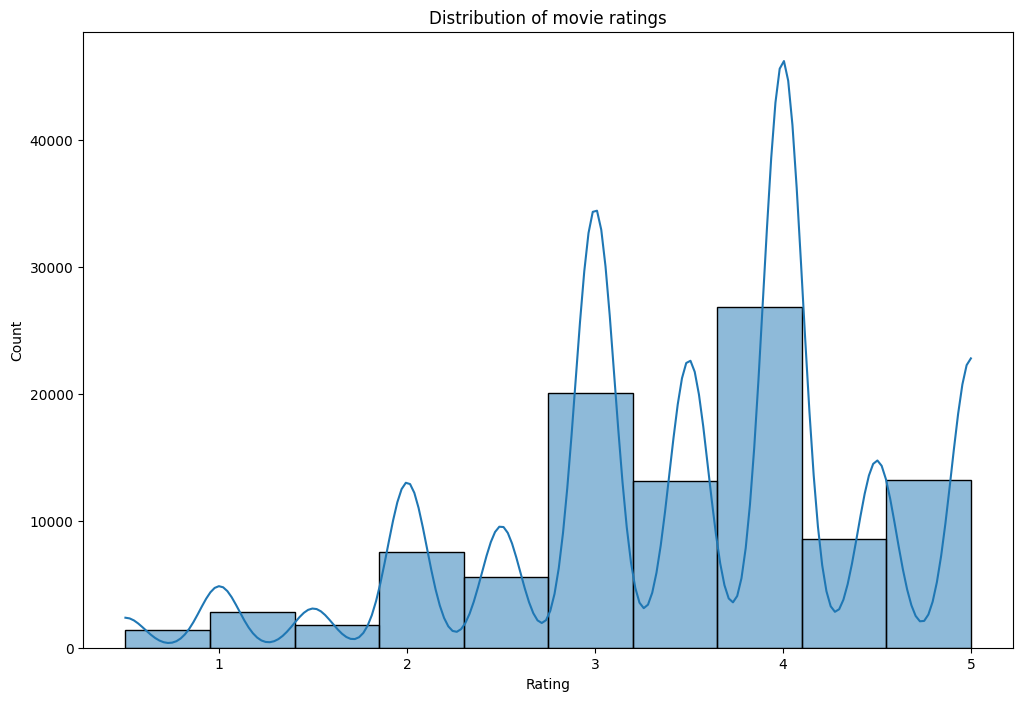

In [54]:
plt.title('Distribution of movie ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
sns.histplot(rat_df['rating'], bins=10, kde=True)
plt.show()

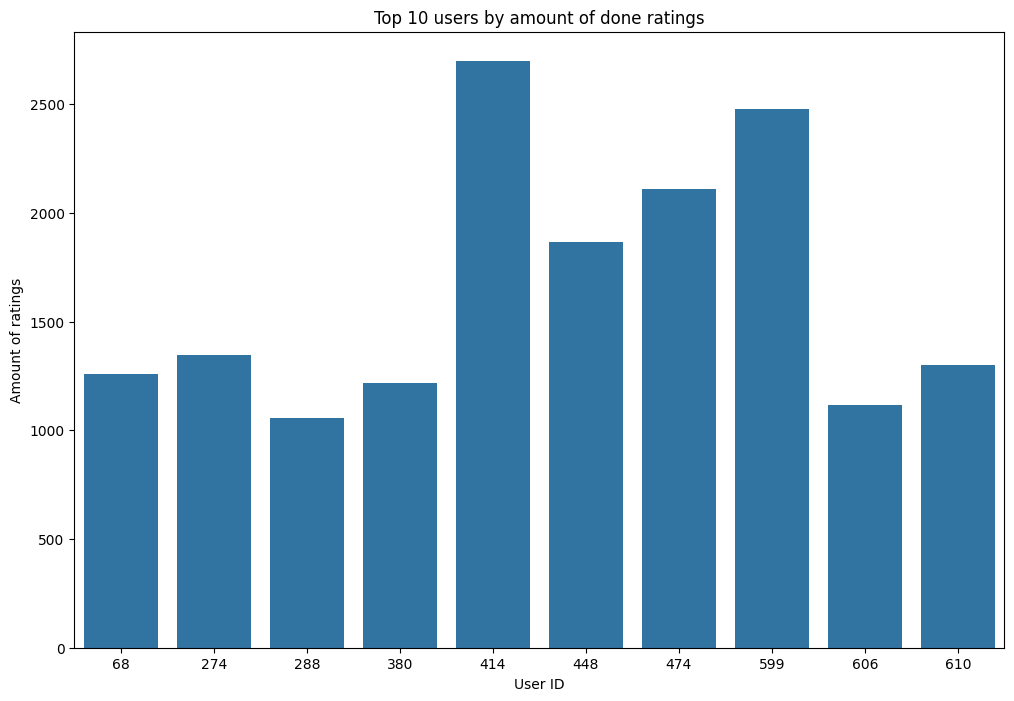

In [55]:
#checking users with highest ammount of rated movies
top_users = rat_df['userId'].value_counts().head(10)

plt.title('Top 10 users by amount of done ratings')
plt.xlabel('User ID')
plt.ylabel('Amount of ratings')
sns.barplot(x=top_users.index, y=top_users.values)
plt.show()

#### Personalized recommendations
Creating a function to make a personalized movie recommendations for one of the users form database 

In [56]:
def userdf_recoms(user_id, genre, recom_movies):

    users_movs = rat_df.pivot(index='userId', columns='movieId' , values='rating')
    similar = cosine_similarity(users_movs.fillna(0))
    
    #finding most similar user to currently compared
    user_index = users_movs.index.get_loc(user_id)


    similar_users = similar[user_index]
    similar_users_index = np.argsort(-similar_users)[1:] #argsort to get users indexes (descending order )
    
    similar_users_id = users_movs.index[similar_users_index]
    similar_users_rats = users_movs.loc[similar_users_id]


    rats_mean = similar_users_rats.mean(axis=0) 
    user_rat_movs = users_movs.loc[user_id].dropna().index
    rats_mean = rats_mean.drop(user_rat_movs, errors='ignore')
    
    if genre:
        genre_movs = mov_df[mov_df['genres'].str.contains(genre, case=False, na=False)]
        rats_mean = rats_mean[rats_mean.index.isin(genre_movs['movieId'])] 
    
    top_recoms = rats_mean.sort_values(ascending=False).head(recom_movies)
    
    final_recoms = top_recoms.to_frame(name='predicted_rating')
    final_recoms = final_recoms.join(mov_df.set_index('movieId')['genres'])
    final_recoms = final_recoms.join(mov_df.set_index('movieId')['title'])
    
    return final_recoms

Testing personalized recommendations

In [57]:
user_id = 1
genre_filter = 'Comedy'
recommendations = userdf_recoms(user_id, genre_filter, 10)
print(f"Recommended {genre_filter} movies for user {user_id}:")
recommendations

Recommended Comedy movies for user 1:


,predicted_rating,genres,title
movieId,,,
172577,5.0,Animation|Children|Comedy|Fantasy,Last Year's Snow Was Falling (1983)
102217,5.0,Comedy,Bill Hicks: Revelations (1993)
146684,5.0,Animation|Children|Comedy,Cosmic Scrat-tastrophe (2015)
174551,5.0,Comedy,Obsession (1965)
118834,5.0,Comedy,National Lampoon's Bag Boy (2007)
96935,5.0,Comedy|Fantasy|Romance,My Left Eye Sees Ghosts (Ngo joh aan gin diy g...
146662,5.0,Adventure|Animation|Comedy,Dragons: Gift of the Night Fury (2011)
173963,5.0,Comedy,Empties (2007)
140133,5.0,Comedy|Horror,Hollywood Chainsaw Hookers (1988)


In [58]:
user_id = 2
genre_filter = 'Drama'
recommendations = userdf_recoms(user_id, genre_filter,10)
print(f"Recommended {genre_filter} movies for user {user_id}:")
recommendations

Recommended Drama movies for user 2:


,predicted_rating,genres,title
movieId,,,
96832,5.0,Drama|Fantasy|Musical|Mystery|Sci-Fi,Holy Motors (2012)
165959,5.0,Animation|Comedy|Drama,Alesha Popovich and Tugarin the Dragon (2004)
25887,5.0,Comedy|Drama,Tales of Manhattan (1942)
6818,5.0,Drama|War,Come and See (Idi i smotri) (1985)
45503,5.0,Drama,Peaceful Warrior (2006)
5745,5.0,Comedy|Drama,"Four Seasons, The (1981)"
26350,5.0,Drama,"Passenger, The (Professione: reporter) (1975)"
147410,5.0,Comedy|Drama,A Perfect Day (2015)
4454,5.0,Animation|Drama|Sci-Fi|IMAX,More (1998)


### Recommendation system with kNN
Function for recommending k-NN similar movies

In [59]:
def knn_recoms(movie_id, n_neighbors): #change to movie name
    users_movs = rat_df.pivot(index='movieId', columns='userId', values='rating').fillna(0)
    
    knn = NearestNeighbors(metric='cosine', algorithm='brute')
    knn.fit(users_movs.values)
    
    #nearst neighbors
    movie_vector = users_movs.loc[movie_id, :].values.reshape(1, -1)
    neighbors = knn.kneighbors(movie_vector, n_neighbors=n_neighbors+1)
    
    distances = neighbors[0].flatten()
    indices = neighbors[1].flatten()
    

    similar_movs = indices[1:]
    similar_dists = distances[1:]
    

    final_recoms = mov_df[mov_df['movieId'].isin(similar_movs)].copy()
    final_recoms = final_recoms.head(len(similar_dists))
    final_recoms['similarity'] = similar_dists

    final_recoms['title'] = final_recoms['movieId']
    
    return final_recoms

Examples of movie recommendation done via K-Nearest Neighbors model for movie called "A perfect day"

In [60]:
movie_id = 147410
n_neighbors = 3 #amount of movies to recommend
print(f"10 similar movies to movie: A perfect day ")
print(knn_recoms(movie_id, n_neighbors))

10 similar movies to movie: A perfect day 


ValueError: Length of values (3) does not match length of index (1)

#### 